# 네이버 영화리뷰 감성분석 

* 활용할 데이터셋은 네이버 영화의 댓글을 모아 구성된 Naver sentiment movie corpus

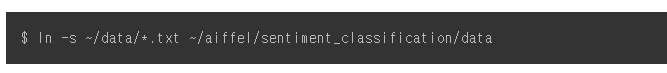

In [1]:
import pandas # version : 1.3.3
import konlpy # version : 0.5.2
import gensim # version : 4.1.2

import os
import numpy as np
import pandas as pd
import tensorflow as tf

from konlpy.tag import Mecab
from collections import Counter

## step 1. Data 준비 및 확인

In [2]:
# 데이터를 읽기
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


## step2. 데이터로더 구성

* nsmc data set은 전혀 가공되지 않은 텍스트 파일로 이루어져있음

* 해주어야 하는 작업 list

> 데이터의 중복 제거
        
> NaN 결측치 제거

> 한국어 토크나이저로 토큰화

> 불용어(Stopwords)제거

> 사전 word_to_index 구성

> 텍스트 스트링을 사전 인덱스 스트링으로 변환

> x_train, y_train, x_test, y_test, word_to_index 리턴

In [3]:
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]  #인덱스 정의
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]  #unknown으로 반환
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [4]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [5]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

## step3. 모델 구성을 위한 데이터 분석 및 가공

* 데이터셋 내 문장 길이 분포 

* 적절한 최대 문장 길이 지정

* Keras.preprocessing.sequence.pad_sequences을 활용한 패딩 추가

In [6]:
total_data_text = list(X_train) + list(X_test)

# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))


# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens) # 최대 길이
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [7]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', # 혹은 'post'
                                                        maxlen=maxlen)

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', # 혹은 'post'
                                                       maxlen=maxlen)

print(X_train.shape)

(146182, 41)


## step4. 모델 구성 및 Validation set 구성

### 1. RNN 모델

In [8]:
# 첫번째 모델
vocab_size_1 = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim_1 = 128  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# model 설계 
model_1 = tf.keras.Sequential()
model_1.add(tf.keras.layers.Embedding(vocab_size_1, word_vector_dim_1, input_shape=(None,)))
model_1.add(tf.keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model_1.add(tf.keras.layers.Dense(8, activation='relu'))
model_1.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_1.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 128)         1280000   
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 4384      
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,284,465
Trainable params: 1,284,465
Non-trainable params: 0
_________________________________________________________________


## step 5. 모델 훈련 개시

In [9]:
# validation set 20000건 분리
x_val = X_train[:20000]   
y_val = y_train[:20000]

# validation set을 제외한 나머지
partial_x_train = X_train[20000:]  
partial_y_train = y_train[20000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(126182, 41)
(126182,)


In [10]:
# model 학습

model_1.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model_1.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
247/247 [==============================] - 5s 8ms/step - loss: 0.5400 - accuracy: 0.7849 - val_loss: 0.4793 - val_accuracy: 0.8399
Epoch 2/10
247/247 [==============================] - 1s 6ms/step - loss: 0.4492 - accuracy: 0.8544 - val_loss: 0.4482 - val_accuracy: 0.8448
Epoch 3/10
247/247 [==============================] - 2s 6ms/step - loss: 0.4045 - accuracy: 0.8685 - val_loss: 0.4253 - val_accuracy: 0.8479
Epoch 4/10
247/247 [==============================] - 2s 6ms/step - loss: 0.3678 - accuracy: 0.8796 - val_loss: 0.4108 - val_accuracy: 0.8480
Epoch 5/10
247/247 [==============================] - 1s 6ms/step - loss: 0.3347 - accuracy: 0.8913 - val_loss: 0.4008 - val_accuracy: 0.8496
Epoch 6/10
247/247 [==============================] - 1s 6ms/step - loss: 0.3053 - accuracy: 0.9000 - val_loss: 0.3967 - val_accuracy: 0.8480
Epoch 7/10
247/247 [==============================] - 1s 6ms/step - loss: 0.2781 - accuracy: 0.9099 - val_loss: 0.4101 - val_accuracy: 0.8487
Epoch 

In [11]:
# 평가
results = model_1.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.4188 - accuracy: 0.8461
[0.41881293058395386, 0.8461256623268127]


## step 6. Loss, Accuracy 그래프 시각화

In [12]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


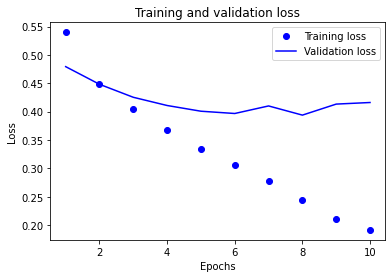

In [13]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

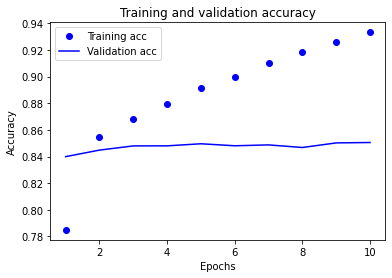

In [14]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## step7. 학습된 Embedding 레이어 분석

In [15]:
embedding_layer = model_1.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 128)


In [16]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec1.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format((vocab_size_1)-4, word_vector_dim_1))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model_1.get_weights()[0]
for i in range(4,vocab_size_1):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [17]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['행복']
vector

array([ 0.13464925, -0.08263987,  0.12299486, -0.08443745, -0.1321882 ,
        0.09806067,  0.11521005,  0.12669109,  0.08359101, -0.11464093,
        0.17687738, -0.1499872 ,  0.107636  ,  0.04818249,  0.17055266,
       -0.08048251, -0.06700324, -0.2039573 , -0.11640814, -0.02741405,
       -0.18588015, -0.12615313, -0.0759533 ,  0.12194749,  0.08726628,
        0.1077558 ,  0.10231893,  0.06730032, -0.07939333, -0.17127262,
        0.08770828, -0.15185009,  0.10720737, -0.14385986,  0.07554452,
       -0.13723025,  0.1362675 ,  0.04633951,  0.05448278, -0.04267988,
       -0.03388198, -0.11992139, -0.11042836,  0.07551411,  0.11724236,
       -0.17287333,  0.06879528,  0.13315679, -0.08158664,  0.04176023,
        0.0952602 , -0.11307721, -0.05199169,  0.1008799 , -0.0369884 ,
        0.13161883,  0.14639644,  0.02197787,  0.03980405,  0.12821165,
        0.19327189,  0.02727452,  0.30070826,  0.11283349, -0.13593416,
        0.10306345,  0.07545228, -0.08399368, -0.0321327 , -0.03

In [18]:
word_vectors.similar_by_word("행복")

[('울컥', 0.9222862124443054),
 ('찡', 0.9206979870796204),
 ('탄탄', 0.9173253774642944),
 ('매트릭스', 0.9150145053863525),
 ('슬픈', 0.9138741493225098),
 ('아름다워요', 0.9137406349182129),
 ('웰메이드', 0.9134831428527832),
 ('황홀', 0.9129595160484314),
 ('였음을', 0.9103987812995911),
 ('에로티시즘', 0.9076643586158752)]

### 2. 1-D Convolution Neural Network (1-D CNN) 모델

In [19]:
# 두번째 모델 
vocab_size_2 = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim_2 = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# model 설계
model_2 =tf.keras.Sequential()
model_2.add(tf.keras.layers.Embedding(vocab_size_2, word_vector_dim_2, input_shape=(None,)))
model_2.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model_2.add(tf.keras.layers.MaxPooling1D(5))
model_2.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model_2.add(tf.keras.layers.GlobalMaxPooling1D())
model_2.add(tf.keras.layers.Dense(8, activation='relu'))
model_2.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_2.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          1808      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [20]:
# validation set 10000건 분리
x_val = X_train[:10000]   
y_val = y_train[:10000]

# validation set을 제외한 나머지 15000건
partial_x_train = X_train[10000:]  
partial_y_train = y_train[10000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(136182, 41)
(136182,)


In [21]:
# model 학습

model_2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model_2.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
266/266 [==============================] - 3s 6ms/step - loss: 0.4764 - accuracy: 0.7614 - val_loss: 0.3497 - val_accuracy: 0.8472
Epoch 2/10
266/266 [==============================] - 1s 4ms/step - loss: 0.3260 - accuracy: 0.8608 - val_loss: 0.3337 - val_accuracy: 0.8546
Epoch 3/10
266/266 [==============================] - 1s 5ms/step - loss: 0.2936 - accuracy: 0.8763 - val_loss: 0.3325 - val_accuracy: 0.8553
Epoch 4/10
266/266 [==============================] - 1s 5ms/step - loss: 0.2647 - accuracy: 0.8913 - val_loss: 0.3332 - val_accuracy: 0.8555
Epoch 5/10
266/266 [==============================] - 1s 5ms/step - loss: 0.2343 - accuracy: 0.9067 - val_loss: 0.3480 - val_accuracy: 0.8534
Epoch 6/10
266/266 [==============================] - 1s 5ms/step - loss: 0.2010 - accuracy: 0.9228 - val_loss: 0.3736 - val_accuracy: 0.8514
Epoch 7/10
266/266 [==============================] - 1s 5ms/step - loss: 0.1698 - accuracy: 0.9372 - val_loss: 0.4228 - val_accuracy: 0.8452
Epoch 

In [22]:
# 평가
results = model_2.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.5552 - accuracy: 0.8318
[0.555179238319397, 0.8318449258804321]


###  1-D CNN 모델 Loss, Accuracy 그래프 시각화

In [23]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


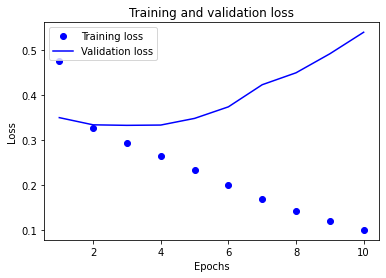

In [24]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

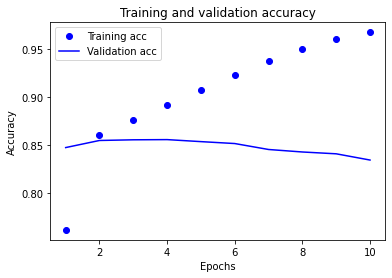

In [25]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### 1- D CNN 모델 학습된 Embedding 레이어 분석

In [26]:
embedding_layer = model_2.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 16)


In [27]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec2.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format((vocab_size_2)-4, word_vector_dim_2))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model_2.get_weights()[0]
for i in range(4,vocab_size_2):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [28]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['행복']
vector

array([ 0.02470697, -0.02735843, -0.06306361, -0.04760417,  0.08576236,
       -0.0689291 ,  0.0098186 ,  0.07343125,  0.08195675, -0.07002531,
        0.02076113, -0.09780389, -0.11268277,  0.03795661,  0.08852173,
        0.0555155 ], dtype=float32)

In [29]:
word_vectors.similar_by_word("행복")

[('and', 0.8658878207206726),
 ('니콜슨', 0.8480323553085327),
 ('생일', 0.8232195973396301),
 ('공권력', 0.8209062218666077),
 ('아날로그', 0.8096417188644409),
 ('맛깔', 0.7998546957969666),
 ('1997', 0.7948926091194153),
 ('바스코', 0.7942581176757812),
 ('지아', 0.7919552326202393),
 ('자무시', 0.7914971709251404)]

### 3.  GlobalMaxPooling1D모델

In [30]:
# 3번째 모델
vocab_size_3 = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim_3 = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# model 설계
model_3= tf.keras.Sequential()
model_3.add(tf.keras.layers.Embedding(vocab_size_3, word_vector_dim_3, input_shape=(None,)))
model_3.add(tf.keras.layers.GlobalMaxPooling1D())
model_3.add(tf.keras.layers.Dense(8, activation='relu'))
model_3.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 160,145
Trainable params: 160,145
Non-trainable params: 0
_________________________________________________________________


In [31]:
# validation set 10000건 분리
x_val = X_train[:10000]   
y_val = y_train[:10000]

# validation set을 제외한 나머지 15000건
partial_x_train = X_train[10000:]  
partial_y_train = y_train[10000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(136182, 41)
(136182,)


In [32]:
# model 학습

model_3.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model_3.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
266/266 [==============================] - 1s 4ms/step - loss: 0.5774 - accuracy: 0.7361 - val_loss: 0.4093 - val_accuracy: 0.8246
Epoch 2/10
266/266 [==============================] - 1s 3ms/step - loss: 0.3681 - accuracy: 0.8420 - val_loss: 0.3528 - val_accuracy: 0.8442
Epoch 3/10
266/266 [==============================] - 1s 3ms/step - loss: 0.3228 - accuracy: 0.8629 - val_loss: 0.3451 - val_accuracy: 0.8457
Epoch 4/10
266/266 [==============================] - 1s 3ms/step - loss: 0.2979 - accuracy: 0.8755 - val_loss: 0.3463 - val_accuracy: 0.8491
Epoch 5/10
266/266 [==============================] - 1s 3ms/step - loss: 0.2795 - accuracy: 0.8840 - val_loss: 0.3494 - val_accuracy: 0.8499
Epoch 6/10
266/266 [==============================] - 1s 3ms/step - loss: 0.2642 - accuracy: 0.8920 - val_loss: 0.3569 - val_accuracy: 0.8481
Epoch 7/10
266/266 [==============================] - 1s 3ms/step - loss: 0.2513 - accuracy: 0.8980 - val_loss: 0.3632 - val_accuracy: 0.8476
Epoch 

In [33]:
# 평가
results = model_3.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.4066 - accuracy: 0.8400
[0.40663838386535645, 0.8400024175643921]


###  GlobalMaxPooling1D모델 Loss, Accuracy 그래프 시각화

In [34]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


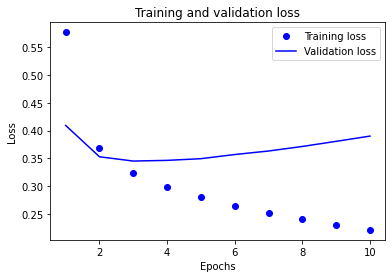

In [35]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

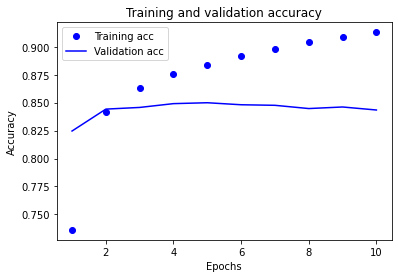

In [36]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### GlobalMaxPooling1D 모델 학습된 Embedding 레이어 분석

In [37]:
embedding_layer = model_3.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 16)


In [38]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec3.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format((vocab_size_3)-4, word_vector_dim_3))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model_3.get_weights()[0]
for i in range(4,vocab_size_3):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [39]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['행복']
vector

array([ 0.05911953, -0.12373288,  0.0217383 ,  0.24647248, -0.18601122,
       -0.09207473, -0.06792171, -0.10662287, -0.14538813, -0.12588108,
       -0.15466727, -0.07926963,  0.06053705,  0.03099732, -0.09249906,
        0.01824083], dtype=float32)

In [40]:
word_vectors.similar_by_word("행복")

[('어쨌든', 0.8828781843185425),
 ('비장', 0.8517617583274841),
 ('행세', 0.8429000973701477),
 ('슬픔', 0.8279581665992737),
 ('묘미', 0.8266044855117798),
 ('비판', 0.7916797399520874),
 ('레이', 0.787691056728363),
 ('뒤집', 0.7874531149864197),
 ('갈구', 0.7854977250099182),
 ('트', 0.785327672958374)]

## step8. 한국어 Word2Vec임베딩 활용하여 성능 개선

In [41]:
# 한국어 Word2Vec 임베딩 활용한 성능 개선
from gensim.models import Word2Vec

word2vec_path = '/aiffel/aiffel/sentiment_classification/data/word2vec_ko.model'
word2vec =  Word2VecKeyedVectors.load(word2vec_path)

vector = word2vec.wv['행복']
vector

array([ 3.6889346 , -3.2576382 , -2.6349437 , -0.11572476,  0.58762413,
       -0.16673814,  0.9697601 ,  0.27856505, -0.92762107,  2.241611  ,
        2.8666036 ,  0.458429  , -2.007293  ,  1.9756018 ,  2.9543707 ,
        0.17504454, -1.0210766 ,  0.6119247 ,  0.9948327 , -2.6716058 ,
       -3.3571372 ,  2.8433375 , -0.64212775,  0.2906057 ,  0.66890335,
        0.6893659 ,  0.19818003,  0.8735505 ,  2.6482987 , -0.188396  ,
       -1.997001  , -2.1050427 , -3.5394318 ,  0.57390505,  0.09716978,
        1.7057031 , -2.3355813 ,  1.624613  ,  0.27012238,  1.6980075 ,
       -1.5318449 , -0.59364384, -1.3710705 ,  3.4411204 ,  1.1825829 ,
        2.1342924 ,  2.8075287 ,  2.1308038 ,  2.7114947 , -0.3305534 ,
        2.3805175 , -0.04170982,  1.2907016 , -2.8457797 , -0.91359496,
       -3.9291334 ,  0.3625686 , -1.7948011 ,  1.1991819 ,  3.9061072 ,
        4.1032424 , -0.88820845,  1.1552868 , -3.5846636 , -1.7109742 ,
       -2.9963055 , -0.5262824 , -0.2760053 , -1.5208707 , -0.90

In [42]:
# 단어를 하나 주고 가장 유사한 단어와 유사도 확인
word2vec.wv.similar_by_word("행복")

[('사랑', 0.7550067901611328),
 ('소중', 0.7270511388778687),
 ('고독', 0.7223575711250305),
 ('영원', 0.7196939587593079),
 ('친절', 0.7095474600791931),
 ('평온', 0.7088841199874878),
 ('삶', 0.6893891096115112),
 ('안녕', 0.6871559023857117),
 ('애틋', 0.6864286065101624),
 ('꿈', 0.6853601932525635)]

In [43]:
from tensorflow.keras.initializers import Constant
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 100  # 워드 벡터의 차원수
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec.wv:
        embedding_matrix[i] = word2vec.wv[index_to_word[i]]

In [49]:
# 모델 구성
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning

model.add(tf.keras.layers.LSTM(256))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 41, 100)           1000000   
_________________________________________________________________
lstm_2 (LSTM)                (None, 256)               365568    
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 257       
Total params: 1,365,825
Trainable params: 1,365,825
Non-trainable params: 0
_________________________________________________________________


In [50]:
# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20 # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
266/266 [==============================] - 8s 24ms/step - loss: 0.4529 - accuracy: 0.7833 - val_loss: 0.3657 - val_accuracy: 0.8373
Epoch 2/20
266/266 [==============================] - 6s 23ms/step - loss: 0.3302 - accuracy: 0.8555 - val_loss: 0.3197 - val_accuracy: 0.8618
Epoch 3/20
266/266 [==============================] - 6s 23ms/step - loss: 0.2809 - accuracy: 0.8802 - val_loss: 0.3129 - val_accuracy: 0.8644
Epoch 4/20
266/266 [==============================] - 6s 23ms/step - loss: 0.2471 - accuracy: 0.8977 - val_loss: 0.3088 - val_accuracy: 0.8669
Epoch 5/20
266/266 [==============================] - 6s 24ms/step - loss: 0.2157 - accuracy: 0.9121 - val_loss: 0.3181 - val_accuracy: 0.8696
Epoch 6/20
266/266 [==============================] - 6s 23ms/step - loss: 0.1815 - accuracy: 0.9280 - val_loss: 0.3394 - val_accuracy: 0.8619
Epoch 7/20
266/266 [==============================] - 6s 23ms/step - loss: 0.1509 - accuracy: 0.9417 - val_loss: 0.3738 - val_accuracy: 0.8652

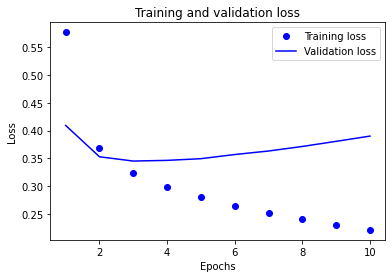

In [51]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

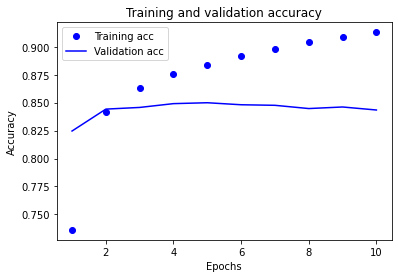

In [52]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [53]:
# 평가
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.8534 - accuracy: 0.8520
[0.8533574342727661, 0.8519641160964966]


# 회고

### 3가지 모델 구현 결과
 * RNN 모델 :  0.8467
 * 1-D Convolution Neural Network(1-D CNN)모델 : 0.8344
 * GlobalMaxPooling1D : 0.8399
 
 3가지 모델 중 **가장 성능이 좋은 모델은 RNN 모델**이였다. 
 
 ### 한국어 Word2Vec를 활용한 LSTM 모델
 * 처음 연결부터 힘들었던 부분이였고 경로문제가 아닌 파일 이상(2가지 파일이 필요했으나 1가지 파일만 다운받아져있음)으로 시간이 많이 걸린 부분이다
#### 85%의 정확도를 위한 시도 
* 1차 : LSTM(8), epochs =20 ,batch_size = 512 => 0.8454
* 2차 : LSTM(32), epochs =20 ,batch_size = 512 => 0.8490
* 3차 : LSTM(32), epochs =30 ,batch_size = 512 => 0.8424 // epochs 늘릴수록 정확도가 떨어지는것 확인 
* 4차 : LSTM(64), epochs =20 ,batch_size = 512 => 0.8453
* 5차 : LSTM(128), epochs =20 ,batch_size = 512 => 0.8494 // LSTM 차원 수를 늘릴수록 정확도가 조금씩 좋아지는것을 확인
* 6차 : LSTM(256), epochs =20 ,batch_size = 512 => 0.8520